In [1]:
#pip install tensorflow
#pip install tabulate

#Data
import numpy as np
import pandas as pd
import math

#Charts and visulaization
import matplotlib as mp
import matplotlib.pyplot as plt
#import plotly 
#import plotly.express as px
#import plotly.graph_objects as go
#from tabulate import tabulate

#NNs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten
from keras.layers import ConvLSTM2D


In [2]:
import glob
import pandas as pd

# Set the path to the folder containing the CSV files depending on the PC
#data1 = r"C:\Users\guilherme.salvador\OneDrive - 501101365 - Rangel Invest SA\XLS_rangel_files\Job_Info1.xls"
##data2 = r"C:\Users\guilherme.salvador\OneDrive - 501101365 - Rangel Invest SA\XLS_rangel_files\Job_Info2.xls"
##data3 = r"C:\Users\guilherme.salvador\OneDrive - 501101365 - Rangel Invest SA\XLS_rangel_files\Job_Info3.xls"

data1 = r"C:\Users\Salvador\OneDrive - FCT NOVA\01- Documents\(1) Dissertação\(R) ML_Model\Job_table_info_V2\Job_Info1.xls"
data2 = r"C:\Users\Salvador\OneDrive - FCT NOVA\01- Documents\(1) Dissertação\(R) ML_Model\Job_table_info_V2\Job_Info2.xls"
data3 = r"C:\Users\Salvador\OneDrive - FCT NOVA\01- Documents\(1) Dissertação\(R) ML_Model\Job_table_info_V2\Job_Info3.xls"
 
# Merge the 3 excel files into 'data'
data1 = pd.read_excel(data1)
data2 = pd.read_excel(data2)
data3 = pd.read_excel(data3)
data = pd.concat([data1, data2, data3], ignore_index=True)
# data = pd.read_excel(data1)

In [3]:
# Convert the date column to the appropriate date format
data['jobdate'] = pd.to_datetime(data['jobdate'])

# Extract the month from the date column
data['Year'] = data['jobdate'].dt.year
data['Month'] = data['jobdate'].dt.month

# Ensure that the freight cost column is in numeric format
data['frete'] = pd.to_numeric(data['frete'])

data = pd.DataFrame (data)
data.head()

C:\Users\Salvador\Documents\Coding\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/04/2203' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Salvador\Documents\Coding\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/03/2025' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Salvador\Documents\Coding\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27/07/2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Salvador\Documents\Coding\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: User

,jobno,custname,jobdate,biztype,departure_loc,destino,frete,incoterm,total_volume_cbm,ownerid,servicetype,bizscope,ctnqty1,ctnqty2,ctnqty3,ctnqty4,polname,podname,Year,Month
0,HAISID2300014,GRUPO DESPORTIVO RECREATIVO E CULTURAL PRETORIA,2203-04-15,AI,Lisboa,Ilha do Sal,17752.67,CFR,0.1200,SID,PTP,W,NaN,NaN,NaN,NaN,Lisboa,Ilha do Sal,2203,4
1,JNBIL2301115,SPEEDLINK PROJECTS & TRADE PVT LTD,2033-05-06,IL,NaN,NaN,226432.00,CFR,NaN,JNB,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,2033,5
2,HSEPDL2300228,"SEGMA SERVICOS DE ENGENHARIA, GESTAO E MANUTEN...",2025-03-13,SE,Ponta Delgada,Terceira Island Apt,16.00,CIF,0.0219,PDL,PTD,I,NaN,NaN,NaN,NaN,Ponta Delgada,Terceira Island Apt,2025,3
3,HSEPDL2300226,ISLAND IMPORT - IMPORTACAO DE PRODUTOS ALIMENT...,2025-03-13,SE,Ponta Delgada,Terceira Island Apt,100.80,CIF,2.8800,PDL,PTD,I,NaN,NaN,NaN,NaN,Ponta Delgada,Terceira Island Apt,2025,3
4,HSEPDL2300227,"SEGMA SERVICOS DE ENGENHARIA, GESTAO E MANUTEN...",2025-03-13,SE,Ponta Delgada,Terceira Island Apt,16.00,CIF,0.0120,PDL,PTD,I,NaN,NaN,NaN,NaN,Ponta Delgada,Terceira Island Apt,2025,3


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:(i + seq_size)]
        x.append(window)
        y.append(dataset[i + seq_size])
        
    return np.array(x), np.array(y)

data_test = np.array(data['frete'])
data_test = data_test.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.reshape(data_test, (-1, 1)))

# split into train and test sets
train_size = int(len(dataset) * 0.6666)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

# Create sequences for training
seq_length = 10
trainX, trainY = to_sequences(train, seq_size=seq_length)
testX, testY = to_sequences(test, seq_size=seq_length)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(96508, 10, 1) (96508, 1)
(48264, 10, 1) (48264, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3016/3016 - 8s - loss: 8.8749e-05 - val_loss: 1.9741e-05 - 8s/epoch - 3ms/step
Epoch 2/5
3016/3016 - 5s - loss: 8.5826e-05 - val_loss: 1.4775e-05 - 5s/epoch - 2ms/step
Epoch 

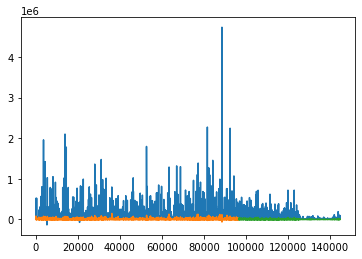

In [5]:
seq_size = 10

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

#Defining the model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

###############################################
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=5)


# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Reshape trainY and testY to 2D arrays
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

# Inverse transform predictions and target values
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

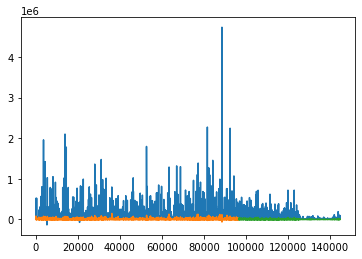

In [6]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Exprimentar para só uma empresa